In [29]:
#코랩 연결 # 모델 저장 or 불러오기
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [34]:
import os

if not os.path.exists(os.path.join('./drive/MyDrive/saved_model')):
  os.mkdir(os.path.join('./drive/MyDrive/saved_model')) #data 하위 폴더로 test생성 
  print("파일 생성 완료")

file_list=os.listdir('./drive/MyDrive/saved_model')
print(file_list) # 빈리스트 or MEDVISION.hdf5 나오면 정상

[]


In [35]:
#학습에 필요한거 함수 가져오기
from tensorflow.keras.models import Sequential # 모델 생성
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D #CNN 모델을 구성하기 위해 필요한 라이브러리 가져옴
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping # 콜백 함수
from tensorflow.keras.preprocessing.image import ImageDataGenerator #소형의 데이터셋을 확대,회전 등으로 여러가지 사진으로 만들어줌
from keras.applications.mobilenet import MobileNet #전이 학습 모델
from tensorflow.keras import optimizers #최적화 알고리즘 가져오기기

# from tensorflow.keras.utils import to_categorical #분류 원핫인코딩

# 파일경로 관련
import sys
import os

#그림그리는 라이브러리리
import matplotlib.pyplot as plt
from PIL import Image

import numpy as np #수치 계산

#데이터 가져오기
!git clone https://github.com/jangjunho2/data.git

fatal: destination path 'data' already exists and is not an empty directory.


data/train/asprin2/asprin2.0.jpg


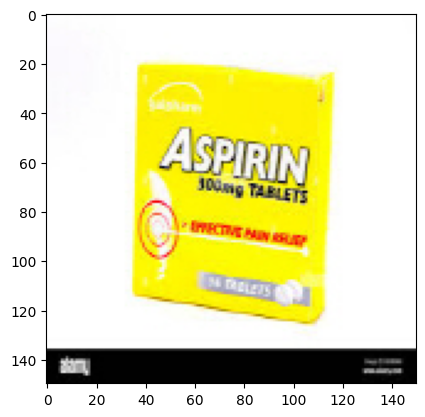

In [44]:
# 학습셋이 있는 폴더의 위치입니다.
#  './data/train',   

# 첫 번째 이미지를 확인해 봅시다.

# 이미지 경로 설정
image_path = os.path.join('data', 'train','asprin2', 'asprin2.0.jpg')
print(image_path)

# 이미지 로드
img = Image.open(image_path)

# 이미지 출력
plt.imshow(img)
plt.show()

In [45]:
#필요한 폴더 생성

if not os.path.exists(os.path.join('data/test')):
  os.mkdir(os.path.join('data/test')) #data 하위 폴더로 test생성 


if not os.path.exists(os.path.join('data/test_image_files')):
  os.mkdir(os.path.join('data/test_image_files')) #data 하위 폴더로 test_image_files 생성


#데이터 불러오기 (train 데이터의 10% 비율로 test 데이터 생성성)

In [46]:
import glob #파일 이름의 패턴 매칭(*.txt 이런식으로 가져올 수 있게 만들어 줌)
import shutil #파일 복사 , 이동
ratio=0.1 # train : test = 9 : 1

src_root_dir=os.path.join('data/train/') # 원본
dst_root_dir=os.path.join('data/test/') # 복사,이동할 목적지지

label_name_list=os.listdir(src_root_dir) #train 하위 폴더 이름들 리스트로 생성

print(label_name_list)

for label_name in label_name_list: #test 디렉토리에 label 디렉토리 생성 (label = 폴더이름이자 정답)
  dst_label_name_dir=dst_root_dir + label_name #경로 지정  "data/test" + "약 이름"

  if not os.path.exists(dst_label_name_dir):
    os.mkdir(dst_label_name_dir) # 위에서 지정한 경로로 폴더 생성

for label_name in label_name_list: #처음에 지정한 만큼 비율로 test할때 쓰기위해 파일이동
  train_image_file_list=glob.glob(src_root_dir+label_name+'/*') # train파일안의 + ex)asprin2 폴더 안의 + *(모든 파일) 다 긁어서 리스트로 만듬
  split_num=int(ratio*len(train_image_file_list)) # 위에서 만든 리스트 * ratio 만큼 , float자료형으로 나오면 7.7 이런식이라 int로 캐스팅
  test_image_file_list=train_image_file_list[0:split_num] #윗줄에서 나온 숫자(split_num) 갯수 만큼 이름을 가져와 리스트로 만듬 

  for image_file in test_image_file_list: # list:파일이름들
    shutil.move(image_file,dst_root_dir+label_name) # 파일 이름, 옮겨질 장소 ex) data/test/asprin2


['mucinex2', 'cepacol2', 'asprin2', 'zicam2']


#데이터 불러오기 (test->test_image_files) #copy

In [47]:
src_root_dir=os.path.join('data/test/')# 원본
dst_root_dir=os.path.join('data/test_image_files/') # 복사,이동할 목적지

label_name_list=os.listdir(src_root_dir)#test 하위 폴더 이름들 리스트로 생성

for label_name in label_name_list: #파일 복사 과정
  image_file_list=glob.glob(src_root_dir+label_name+'/*')# test 파일안의 + ex)asprin2 폴더 안의 + *(모든 파일) 다 긁어서 리스트로 만듬
  print(f"total [{label_name}] image file nums -> {len(image_file_list)}")

  copy_nums=0

  for image_file in image_file_list:
    shutil.copy(image_file,dst_root_dir) #copy
    copy_nums+=1

    # print('total copy nums=> ', copy_nums)

total [mucinex2] image file nums -> 63
total [cepacol2] image file nums -> 52
total [asprin2] image file nums -> 60
total [zicam2] image file nums -> 44


#imageDataGenerator 정의


In [48]:
img_width=150
img_height=150

train_dir=os.path.join('data/train')
validation_dir=os.path.join('data/train')
test_dir=os.path.join('data/test')

train_datagen=ImageDataGenerator(rescale=1./255,            #데이터 정규화
                                 rotation_range=20,         # 정해진 각도만큼 회전시킵니다.
                                 width_shift_range=0.2,     # 전체 크기의 10% 범위에서 좌우로 이동합니다.
                                 height_shift_range=0.2,    # 마찬가지로 위, 아래로 이동합니다.
                                 shear_range=0.2,           # 좌표 하나를 고정시키고 나머지를 이동시킵니다
                                 zoom_range=0.2,            # 확대 또는 축소시킵니다.
                                 validation_split=0.15)     # 15% 비율을 검증용 데이터로 사용합니다.

validation_datagen=ImageDataGenerator(rescale=1./255,validation_split=0.15)   # 15% 비율을 검증용 데이터로 사용합니다.         

In [49]:
train_generator=train_datagen.flow_from_directory(train_dir,batch_size=16,color_mode='rgb', #데이터 경로, 1번에 학습 시킬 갯수, rgb컬러로 학습
                                                class_mode='sparse', #이미지 데이터의 라벨을 어떻게 처리할지를 설정 
                                                subset='training', #위에서 validation=0.15로 검증용15%,학습용85% 중에 학습용 85% 로 학습습  
                                                target_size=(img_width,img_height)) #이미지 가로,세로 크기지정

validation_generator=validation_datagen.flow_from_directory(validation_dir,batch_size=16,color_mode='rgb',
                                                          class_mode='sparse',subset='validation',
                                                          target_size=(img_width,img_height))


print(train_generator.class_indices)

#밑에 설명 classmode를 원핫인코딩이 아닌 sparse로 선택한 이유

Found 520 images belonging to 4 classes.
Found 88 images belonging to 4 classes.
{'asprin2': 0, 'cepacol2': 1, 'mucinex2': 2, 'zicam2': 3}


class_mode 매개변수는 ImageDataGenerator 클래스의 생성자에서 사용되는 인수 중 하나입니다. 이 인수는 이미지 데이터의 라벨을 어떻게 처리할지를 설정하는 데 사용됩니다.

class_mode 매개변수에 'sparse'를 설정하면, 라벨이 정수형 값으로 주어지며, 이 값은 클래스의 인덱스를 나타냅니다. 즉, 이미지 데이터의 라벨이 [0, 1, 2, 1, 0, 2, ...]와 같은 형식으로 주어진 경우, sparse 모드를 사용하여 이 라벨을 처리할 수 있습니다.

이와 반대로, class_mode 매개변수를 'categorical'로 설정하면 라벨을 원-핫 인코딩(one-hot encoding) 형식으로 처리합니다. 예를 들어, 클래스가 3개인 경우, 라벨이 [0, 1, 2, 1, 0, 2, ...]와 같은 형식으로 주어진 경우, 이 라벨을 [1, 0, 0], [0, 1, 0], [0, 0, 1], [0, 1, 0], [1, 0, 0], [0, 0, 1], ...와 같은 원-핫 인코딩 형식으로 처리합니다.

class_mode 매개변수를 설정하지 않은 경우, 기본값은 'categorical'입니다. class_mode 매개변수는 이미지 데이터의 라벨을 처리하는 방식을 설정하는 중요한 인수이므로, 사용하는 데이터의 특성에 맞게 적절한 값을 설정해야 합니다.

#모델 구축 (Pre-Trained MobileNet + user_defined classifier)

In [50]:
#전이 학습 모델  불러오기
base_model=MobileNet(weights='imagenet',include_top=False,input_shape=(img_width,img_height,3)) #이미지넷의 mobilenet의 가중치, 특징 추출로만 사용, 입력 크기 150*150(컬러)
# WARNING:tensorflow:`input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.

#모델 생성
model=Sequential() #모델 생성
model.add(base_model) #전이학습
model.add(Flatten()) #위에서 추출된 특징을 1차원 벡터로 변환환
model.add(Dense(32,activation='relu'))#32개의 뉴런을 가지는 완전 연결 레이어
model.add(Dropout(0.25)) # 과적합 방지
model.add(Dense(4,activation='softmax')) #4개의 뉴런을 가지는 완전 연결 레이어
# 소프트맥스 함수는 출력값을 확률값으로 변환하여 각 클래스에 속할 확률을 나타냅니다. 따라서, 이 레이어의 출력값은 4개의 클래스에 속할 확률을 나타내며, 모두 합치면 1이 됩니다.

#모델 컴파일 설정
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=optimizers.Adam(2e-5),metrics=['accuracy']) # 학습률 낮게 설정 전이학습 되어있으니까

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 4, 4, 1024)       3228864   
 nal)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 16384)             0         
                                                                 
 dense_4 (Dense)             (None, 32)                524320    
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_5 (Dense)             (None, 4)                 132       
                                                                 
Total params: 3,753,316
Trainable params: 3,731,428
Non-trainable params: 21,888
_______________________________________

#모델 학습

In [51]:
modelpath="./drive/MyDrive/saved_model/MEDVISION.hdf5"#모델 경로

checkpointer = ModelCheckpoint(filepath=modelpath, monitor='val_loss', verbose=1, save_best_only=True) #모델의 성능이 best 일때만 저장
earlystopping=EarlyStopping(monitor='val_loss',patience=5) # 5회간 학습 없으면 조기종료

#모델 학습
hist=model.fit(train_generator,validation_data=validation_generator,epochs=50,callbacks=[earlystopping,checkpointer])  #학습시킬 데이터,검증데이터,반복횟수,콜백함수(조기종료,저장)

Epoch 1/50
33/33 [==============================] - ETA: 0s - loss: 2.2999 - accuracy: 0.2865
Epoch 1: val_loss improved from inf to 1.77038, saving model to ./drive/MyDrive/saved_model/MEDVISION.hdf5
33/33 [==============================] - 22s 193ms/step - loss: 2.2999 - accuracy: 0.2865 - val_loss: 1.7704 - val_accuracy: 0.2955
Epoch 2/50
33/33 [==============================] - ETA: 0s - loss: 1.6852 - accuracy: 0.3250
Epoch 2: val_loss improved from 1.77038 to 1.35031, saving model to ./drive/MyDrive/saved_model/MEDVISION.hdf5
33/33 [==============================] - 4s 125ms/step - loss: 1.6852 - accuracy: 0.3250 - val_loss: 1.3503 - val_accuracy: 0.4773
Epoch 3/50
33/33 [==============================] - ETA: 0s - loss: 1.3814 - accuracy: 0.3962
Epoch 3: val_loss improved from 1.35031 to 1.13460, saving model to ./drive/MyDrive/saved_model/MEDVISION.hdf5
33/33 [==============================] - 5s 150ms/step - loss: 1.3814 - accuracy: 0.3962 - val_loss: 1.1346 - val_accuracy: 0.

#손실 및 정확도

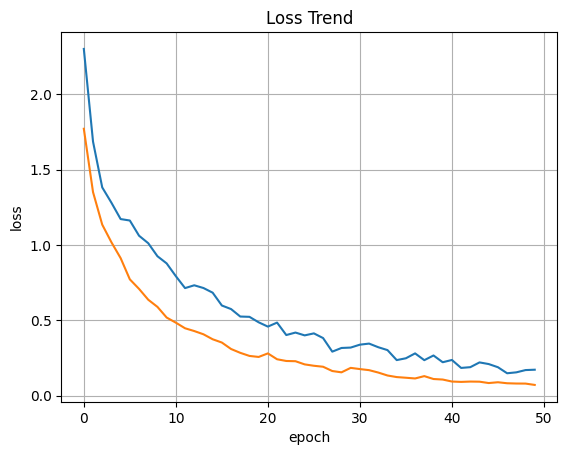

In [52]:
#손실 함수 그래프 출력
plt.plot(hist.history['loss'],label='train')
plt.plot(hist.history['val_loss'],label='validation')
plt.title('Loss Trend')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.grid()
plt.show()

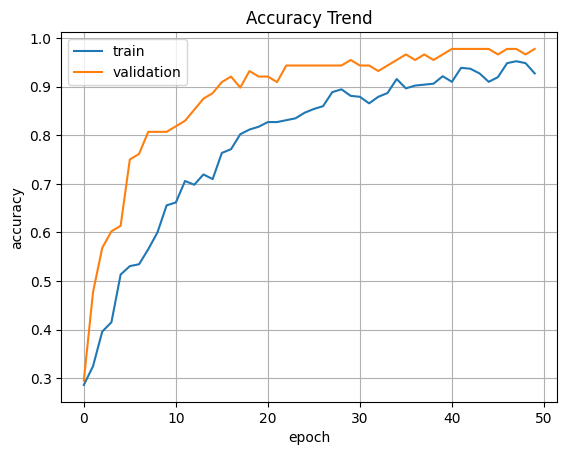

In [53]:
#정확도 그래프 출력

plt.plot(hist.history['accuracy'],label='train')
plt.plot(hist.history['val_accuracy'],label='validation')
plt.title('Accuracy Trend')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(loc='best')
plt.grid()
plt.show()

In [65]:
import random #셔플
import cv2 #opencv 이미지 처리 라이브러리리

label_dict={'asprin2':0,'cepacol2':1,'mucinex2':2,'zicam2':3} #라벨링

test_image_files_list=glob.glob('data/test_image_files/*.jpg') #테스트할 이미지 이름 담긴 리스트

random.shuffle(test_image_files_list)#셔플플

test_num=16 #테스트할 이미지 갯수수

test_image_files=test_image_files_list[:test_num] #태스트 파일이름은 정답,숫자.jpg

label_list=[] #정답만 담을 리스트트

#정답에 해당하는 약품 이름 추출 ex) data/test_image_files/*.jpg  -> *
for i in range(len(test_image_files)):
  label=test_image_files[i].split('/')[-1].split('.')[0].strip()
  label_list.append(label_dict[label])



src_img_list=[]

for i in range(len(test_image_files)):
  src_img=cv2.imread(test_image_files[i],cv2.IMREAD_COLOR) #이미지 읽기
  src_img=cv2.resize(src_img,dsize=(img_width,img_height)) #이미지 크기조정
  src_img=cv2.cvtColor(src_img,cv2.COLOR_BGR2RGB) # BGR -> RGB    opencv는 이미지를 처리할때 BRG값을 씀 다른 곳에써 쓰려면 RGB로 변환 필요  
  src_img=src_img/255.0# 데이터 정규화 ,이미지 데이터는 0~255 까지의 사이값을 가짐 , 0~255 -> 0~1 로 나타냄

  src_img_list.append(src_img) #리스트에 담기


#4차원 텐서 변환
src_img_array=np.array(src_img_list) #[이미지 수, 높이, 너비, 채널 수(RGB)]
label_array=np.array(label_list) # 라벨 리스트 -> 넘파이 배열

In [55]:
pred=model.predict(src_img_array) # 모델 정답 예측
print(pred.shape) #(추측하고자 하는 이미지의 갯수, 정답이 될수 있는 가짓 수)

1/1 [==============================] - 1s 525ms/step
(16, 4)


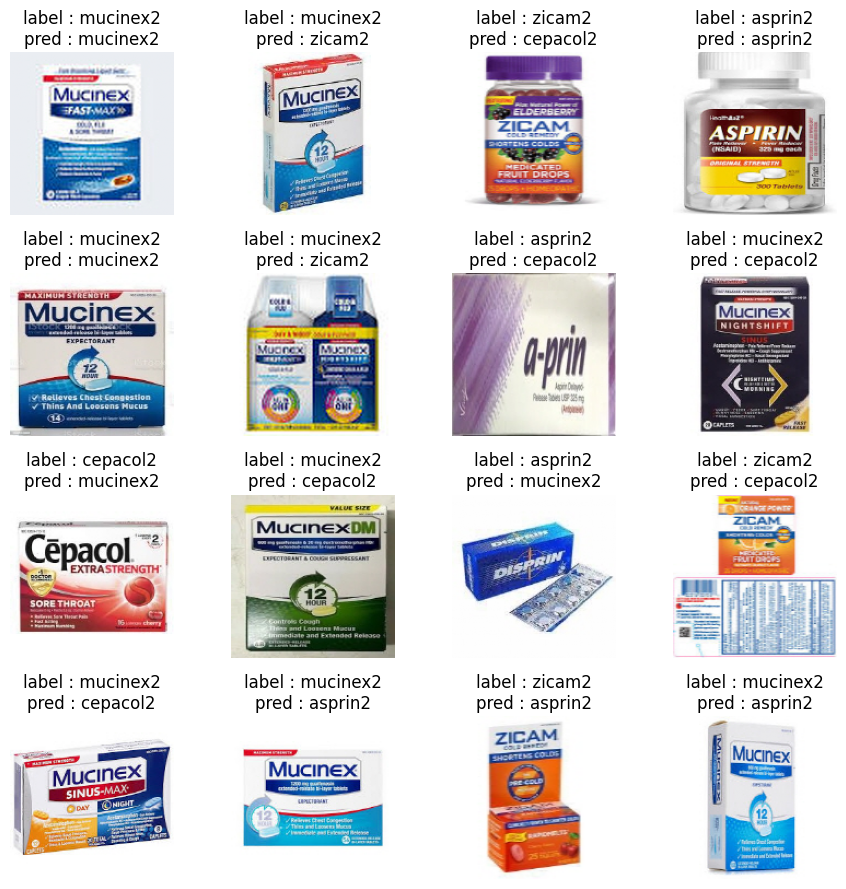

In [76]:
class_names=['asprin2','cepacol2','mucinex2','zicam2'] #정답 라벨링

plt.figure(figsize=(9,9)) #그래프 크기기

for pos in range(len(pred)): #len(pred)==test_num

  plt.subplot(4,4,pos+1) # 4행 4열 pos+1 번째 장소에 출력
  plt.axis('off') # x,y축 숨기기기

  label_str=class_names[label_array[pos]] #정답 이름

  # 소프트맥스 함수는 출력값을 확률값으로 변환하여 각 클래스에 속할 확률을 나타냅니다. 따라서, 이 레이어의 출력값은 4개의 클래스에 속할 확률을 나타내며, 모두 합치면 1이 됩니다.
  pred_str=class_names[np.argmax(pred[pos])] #최댓값 출력을 갖는 원소의 인덱스 반환

  plt.title('label : '+ label_str + "\npred : " + pred_str) # 정답 , 예측  출력력

  plt.imshow(src_img_array[pos]) # 이미지 보여주기

plt.tight_layout() # 각 서브 플롯 이미지 간격 자동 조정
plt.show() # 전체 출력